In [1]:
%pip install lightning torchmetrics transformers[torch] datasets umap-learn imbalanced-learn tensorboard tensorboardX matplotlib evaluate accelerate sentencepiece tensorflow

  Using cached lightning-2.3.0-py3-none-any.whl.metadata (53 kB)
  Using cached torchmetrics-1.4.0.post0-py3-none-any.whl.metadata (19 kB)
  Using cached datasets-2.20.0-py3-none-any.whl.metadata (19 kB)
  Using cached umap_learn-0.5.6-py3-none-any.whl.metadata (21 kB)
  Using cached imbalanced_learn-0.12.3-py3-none-any.whl.metadata (8.3 kB)
  Using cached tensorboard-2.17.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached tensorboardX-2.6.2.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached matplotlib-3.9.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached evaluate-0.4.2-py3-none-any.whl.metadata (9.3 kB)
  Using cached accelerate-0.31.0-py3-none-any.whl.metadata (19 kB)
  Using cached sentencepiece-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached tensorflow-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
  Using cached lightning_utilities-0.11.2-py3-none

In [2]:
%load_ext autoreload
%autoreload 2
import torch
from torch import nn
import lightning as L
import torch.nn.functional as F
from torchmetrics import Accuracy
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import pandas as pd
from lightning.pytorch.loggers import TensorBoardLogger
from datasets import load_dataset, Dataset as DS
import matplotlib.pyplot as plt
import numpy as np
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score
import evaluate
from transformers.integrations import TensorBoardCallback
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%load_ext tensorboard

2024-06-16 19:50:31.697528: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-16 19:50:32.442704: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
revies_ds = load_dataset("csv", data_files="data/train_data.csv", sep=",")
labels = revies_ds['train']['rating']
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
CLS_WEIGHTS = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

## Data stats

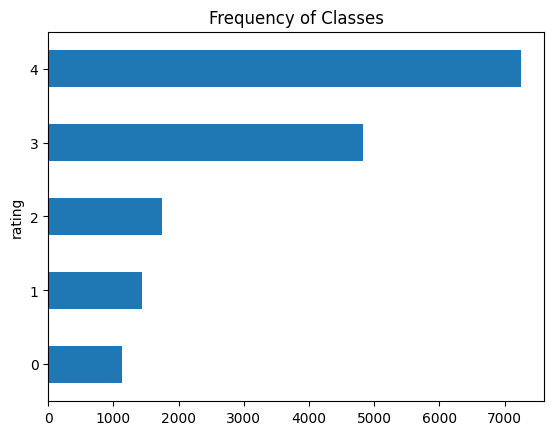

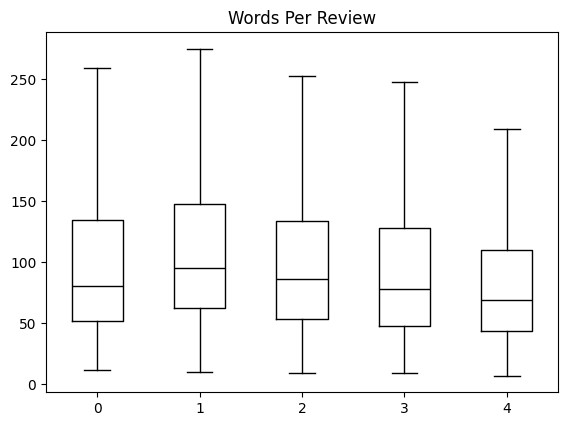

In [3]:
revies_ds = load_dataset("csv", data_files="data/train_data.csv", sep=",")
revies_ds.set_format(type="pandas")
df = revies_ds["train"][:]
df["rating"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()
df["Words Per Review"] = df["review"].str.split().apply(len)
df.boxplot("Words Per Review", by="rating", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()
revies_ds.reset_format()

### Bert embeding layer analysis

In [4]:
MODEL = "distilbert-base-uncased"

In [5]:
def save_embedding_to_pt(csv_path, pt_path, tokenizer, model, has_labels=True):
    if has_labels:
        ds = load_dataset("csv", data_files=csv_path, sep=",")
    else:
        ds = load_dataset("csv", data_files=csv_path, sep=",", names=['review'])
    encoded_ds = ds.map(lambda batch: tokenizer(batch["review"], padding=True, truncation=True), batched=True, batch_size=None)
    if has_labels:
        encoded_ds.set_format("torch", columns=["input_ids", "attention_mask", "rating"])
    else:
        encoded_ds.set_format("torch", columns=["input_ids", "attention_mask"])                         
    def extract_hidden_states(batch):
        inputs = {k:v.to(DEVICE) for k,v in batch.items()
                if k in tokenizer.model_input_names}
        with torch.no_grad():
            last_hidden_state = model(**inputs).last_hidden_state
        return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}
    hidden_ds = encoded_ds.map(extract_hidden_states, batched=True)
    if has_labels:
        torch.save((hidden_ds['train']['hidden_state'], hidden_ds['train']['rating']), pt_path)
    else:
        torch.save(hidden_ds['train']['hidden_state'], pt_path)

In [77]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)
emb_model = AutoModel.from_pretrained(MODEL).to(DEVICE)
save_embedding_to_pt('data/train_data.csv', 'train_ds.pt', tokenizer, emb_model)
save_embedding_to_pt('data/test_data.csv', 'test_ds.pt', tokenizer, emb_model, False)

Map:   0%|          | 0/16392 [00:00<?, ? examples/s]

Map:   0%|          | 0/16392 [00:00<?, ? examples/s]

Map:   0%|          | 0/4099 [00:00<?, ? examples/s]

Map:   0%|          | 0/4099 [00:00<?, ? examples/s]

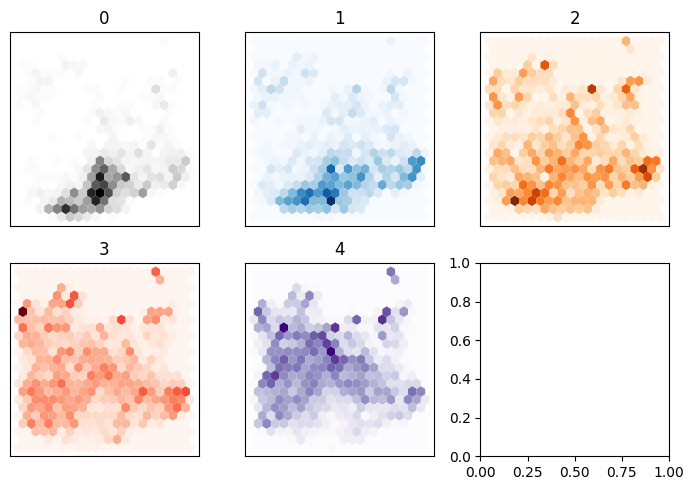

In [78]:
emb_layer, ratings = torch.load("train_ds.pt")
X_train = emb_layer.numpy()
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["rating"] = ratings.numpy()
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples"]
labels = range(0, 5)

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"rating == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

## Bert embeding classifier

In [7]:
class ReviewsEmbedingDataModule(L.LightningDataModule):
    def __init__(self, train_path, test_path, batch_size=32, ratio=0.8, num_workers=27):
        super().__init__()
        self.train_path = train_path
        self.test_path = test_path
        self.batch_size = batch_size
        self.ratio = ratio
        self.workers = num_workers

    def setup(self, stage=None):
        train_data = torch.load(self.train_path)
        self.test_data = torch.load(self.test_path)

        dataset = TensorDataset(train_data[0], train_data[1])


        train_size = int(self.ratio * len(dataset))
        self.train_dataset, self.val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.workers)
    
    def predict_dataloader(self):
        test_dataset = TensorDataset(self.test_data)
        return DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=self.workers)

class MulticlassClassifier(L.LightningModule):
    def __init__(self, input_dim=768, num_classes=5):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(512),
            nn.Linear(512, num_classes)
        )
        self.train_accuracy = Accuracy(num_classes=num_classes, task="multiclass")
        self.val_accuracy = Accuracy(num_classes=num_classes, task="multiclass")

    def forward(self, x):
        return self.classifier(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = F.cross_entropy(outputs, labels, weight=CLS_WEIGHTS)
        preds = torch.argmax(outputs, dim=1)
        self.train_accuracy.update(preds, labels)
        self.log('train_loss', loss, on_epoch=True)
        self.log('train_acc', self.train_accuracy, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        val_loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        self.val_accuracy.update(preds, labels)
        self.log('val_loss', val_loss, on_epoch=True)
        self.log('val_acc', self.val_accuracy, on_epoch=True)
        return val_loss
    
        
    def predict_step(self, batch, batch_idx):
        with torch.no_grad():
            return torch.argmax(self(batch[0]), dim=1)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

train_path = 'train_ds.pt'
test_path = 'test_ds.pt'
# emb_model = AutoModel.from_pretrained(MODEL).to(DEVICE)
# tokenizer = AutoTokenizer.from_pretrained(MODEL)
# save_embedding_to_pt('data/train_data.csv', 'train_ds.pt', tokenizer, emb_model)
# save_embedding_to_pt('data/test_data.csv', 'test_ds.pt', tokenizer, emb_model, False)
reviews_data_module = ReviewsEmbedingDataModule(train_path, test_path)
model = MulticlassClassifier()
logger = TensorBoardLogger("logs")
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=7,
    mode='min'
)

trainer = L.Trainer(max_epochs=20, logger=logger, callbacks=[early_stopping_callback])
trainer.fit(model, reviews_data_module)
pd.DataFrame(trainer.predict(model, reviews_data_module)[0].numpy(), columns=['Values']).to_csv('embeding_result.csv', index=False, header=False)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | classifier     | Sequential         | 397 K  | train
1 | train_accuracy | MulticlassAccuracy | 0      | train
2 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
397 K     Trainable params
0         Non-trainable params
397 K     Total params
1.589     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |          | 0/? [00:00<?, ?it/s]

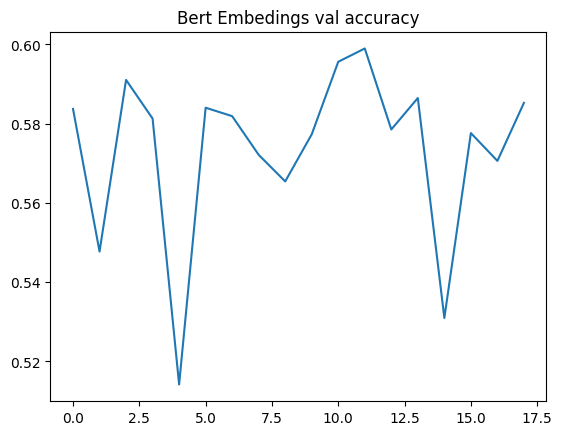

In [10]:
import tensorflow as tf
data = []
for event in tf.compat.v1.train.summary_iterator('/home/NLP-reviews/logs/lightning_logs/version_2/events.out.tfevents.1718566769.a8e42ceae790.62417.0'):
    for value in event.summary.value:
            if value.tag == 'val_acc':
                data.append(value.simple_value)
plt.plot(data)
plt.title("Bert Embedings val accuracy")
plt.show()

Trening trwał bardzo krótko, ponieważ embedingi dla danych zostały policzone raz przed treningiem, a uczenie polegało na nauczenie prostego klasyfikatora.
W czasie eksperymentów kluczowym okazało się ważenie klas, w treningach bez ważenia model zawsze zwracał klasę 4 - najbardziej liczną

## Bert finetuning

In [8]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        """
        How the loss is computed by Trainer. By default, all models return the loss in the first element.
        Subclass and override for custom behavior.
        """
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            logits = outputs['logits']
            criterion = torch.nn.CrossEntropyLoss(weight=self.class_weights)
            loss = criterion(logits, inputs['labels'])

        return (loss, outputs) if return_outputs else loss

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.900847,0.626106,0.626938


/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


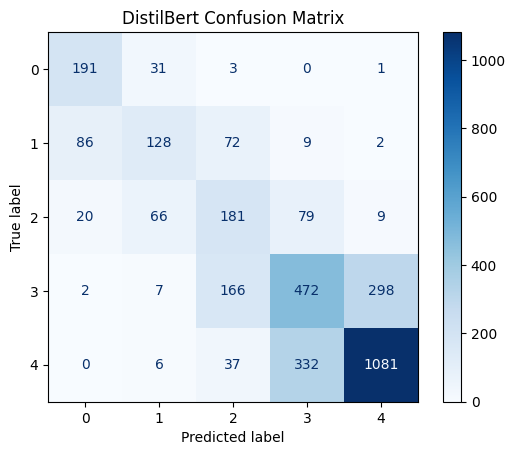

In [27]:
MODEL = "distilbert-base-uncased"
# MODEL = "LiYuan/amazon-review-sentiment-analysis"
# MODEL = "SamLowe/roberta-base-go_emotions"
# MODEL = "roberta-large"

def resample(ds, name):
    train_dataset = ds[name]
    df = pd.DataFrame(train_dataset)
    X, y = df[['input_ids', 'attention_mask']].map(str), df['labels']
    ros = RandomOverSampler(random_state=42)
    X_res_flattened, y_res = ros.fit_resample(X, y)
    X_res = X_res_flattened.map(eval)
    resampled_df = pd.concat([X_res, y_res], axis=1)
    return DS.from_pandas(resampled_df)

def compute_metrics(eval_preds):
    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    return {"accuracy": accuracy["accuracy"], "f1": f1["f1"]}


tokenizer = AutoTokenizer.from_pretrained(MODEL)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


revies_ds = load_dataset("csv", data_files="data/train_data.csv", sep=",")
review_encoded = revies_ds.map(lambda ds: tokenizer(ds['review'], truncation=True), batched=True)
review_encoded=review_encoded.remove_columns(['review'])
review_encoded=review_encoded.rename_column('rating', 'labels')
review_encoded=review_encoded['train'].train_test_split(test_size=0.2)
# review_encoded['train'] = resample(review_encoded, 'train')

num_labels = 5
model = (AutoModelForSequenceClassification
         .from_pretrained(MODEL, num_labels=num_labels)
         .to(DEVICE))
batch_size = 8
accumulation_steps = 4  # Accumulate gradients over 4 steps
logging_steps = len(review_encoded["train"]) // batch_size
training_args = TrainingArguments('bert-finetune',
                                  num_train_epochs=1,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                #   gradient_accumulation_steps=accumulation_steps,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  gradient_accumulation_steps=2,      # Accumulate gradients to fit large batch size
                                  dataloader_num_workers=4,   
                                  fp16=True,
                                  log_level="error")
trainer = WeightedTrainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=review_encoded['train'],
                  eval_dataset=review_encoded['test'],
                  tokenizer=tokenizer,
                  data_collator=data_collator,
                  class_weights=CLS_WEIGHTS,
                  )
# trainer = Trainer(model=model, args=training_args,
#                   compute_metrics=compute_metrics,
#                   train_dataset=review_encoded['train'],
#                   eval_dataset=review_encoded['test'],
#                   tokenizer=tokenizer,
#                   data_collator=data_collator,
#                   )
trainer.train()
trainer.save_model("bert_model")
test_ds = load_dataset("csv", data_files="data/test_data.csv", sep=",", names=['review'])
test_encoded = test_ds.map(lambda ds: tokenizer(ds['review'], truncation=True), batched=True)
test_encoded = test_encoded.remove_columns(['review'])
test_encoded = test_encoded['train']  # If your test data is in a single split
predictions = trainer.predict(test_encoded)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
pd.DataFrame(predicted_labels, columns=['Values']).to_csv('distilbert_result.csv', index=False, header=False)

predictions = trainer.predict(review_encoded['test'])
true_labels = predictions.label_ids
predicted_labels = np.argmax(predictions.predictions, axis=-1)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap=plt.cm.Blues)
plt.title('DistilBert Confusion Matrix')
plt.show()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.803224,0.687710,0.688121


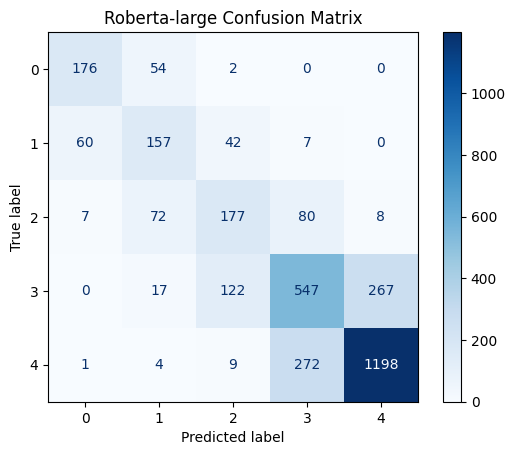

In [9]:
MODEL = "roberta-large"

def compute_metrics(eval_preds):
    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    return {"accuracy": accuracy["accuracy"], "f1": f1["f1"]}


tokenizer = AutoTokenizer.from_pretrained(MODEL)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


revies_ds = load_dataset("csv", data_files="data/train_data.csv", sep=",")
review_encoded = revies_ds.map(lambda ds: tokenizer(ds['review'], truncation=True), batched=True)
review_encoded=review_encoded.remove_columns(['review'])
review_encoded=review_encoded.rename_column('rating', 'labels')
review_encoded=review_encoded['train'].train_test_split(test_size=0.2)

num_labels = 5
model = (AutoModelForSequenceClassification
         .from_pretrained(MODEL, num_labels=num_labels)
         .to(DEVICE))
batch_size = 8
logging_steps = len(review_encoded["train"]) // batch_size
training_args = TrainingArguments('bert-finetune',
                                  num_train_epochs=1,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  gradient_accumulation_steps=2,
                                  dataloader_num_workers=4,   
                                  fp16=True,
                                  log_level="error")
trainer = WeightedTrainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=review_encoded['train'],
                  eval_dataset=review_encoded['test'],
                  tokenizer=tokenizer,
                  data_collator=data_collator,
                  class_weights=CLS_WEIGHTS,
                  )
trainer.train()

predictions = trainer.predict(review_encoded['test'])
true_labels = predictions.label_ids
predicted_labels = np.argmax(predictions.predictions, axis=-1)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1, 2, 3, 4])
disp.plot(cmap=plt.cm.Blues)
plt.title('Roberta-large Confusion Matrix')
plt.show()

Roberta-large dała lepsze rezultaty niż jej dystylowana wersja - 60%->69%

### microsoft/deberta-large
Batch-size: 1
{'eval_loss': 0.6429851651191711, 'eval_accuracy': 0.7267459591338823, 'eval_f1': 0.721880869461863, 'eval_runtime': 28.483, 'eval_samples_per_second': 115.121, 'eval_steps_per_second': 28.789, 'epoch': 1.0} 
![](DeBERT_confusion_matrix.png)

Trening trwał znacznie dłuzej i wymagał użycia znaczych zasobów obliczeniowych (4x 48GB VRAM), jednakże dało to znacznie lepsze rezultaty.
Wyniki pochodzą z wykonania pliku `deberta_large.py`

## BOW and TF-IDF

In [4]:
df = pd.read_csv('data/train_data.csv')

vectorizer = CountVectorizer(analyzer='word',
                             tokenizer=None,
                             preprocessor=None,
                             stop_words=None,
                             max_features=1500)

train_data_features = vectorizer.fit_transform(df['review'])

train_data_features = train_data_features.toarray()
print('Bag of words completed')
X = train_data_features
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['rating'], test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Bag of words completed
0.6160414760597743
              precision    recall  f1-score   support

           0       0.71      0.60      0.65       242
           1       0.47      0.41      0.44       277
           2       0.40      0.24      0.30       352
           3       0.52      0.52      0.52       961
           4       0.71      0.82      0.76      1447

    accuracy                           0.62      3279
   macro avg       0.56      0.52      0.53      3279
weighted avg       0.60      0.62      0.60      3279



In [5]:
class BoWModel(L.LightningModule):
    def __init__(self, num_classes: int, learning_rate: float = 1e-4):
        super().__init__()
        self.save_hyperparameters()

        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task='multiclass', num_classes=num_classes)
        self.learning_rate = learning_rate

        self.model = nn.Sequential(
            nn.Linear(1500, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        review, labels = batch
        logits = self(review)
        loss = self.criterion(logits, labels)
        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(logits, labels), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        review, labels = batch
        logits = self(review)
        loss = self.criterion(logits, labels)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy(logits, labels), prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)

train_indices = np.random.rand(len(df)) > 0.2
train_data = torch.from_numpy(train_data_features).float()[train_indices]
train_targets = torch.from_numpy(df["rating"].values[train_indices]).long()

test_data = torch.from_numpy(train_data_features[~train_indices]).float()
test_targets = torch.from_numpy(df["rating"].values[~train_indices]).long()
train_dataset = TensorDataset(train_data, train_targets)
val_dataset = TensorDataset(test_data, test_targets)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
logger = TensorBoardLogger("logs")
bow_model = BoWModel(num_classes=5)
trainer = L.Trainer(
    max_epochs=30, 
    callbacks=[L.pytorch.callbacks.EarlyStopping(monitor='val_loss', patience=7, strict=False, verbose=False, mode='min')],
    logger=logger
)

trainer.fit(bow_model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | criterion | CrossEntropyLoss   | 0      | train
1 | accuracy  | MulticlassAccuracy | 0      | train
2 | model     | Sequential         | 935 K  | train
---------------------------------------------------------
935 K     Trainable params
0         Non-trainable params
935 K     Total params
3.741     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


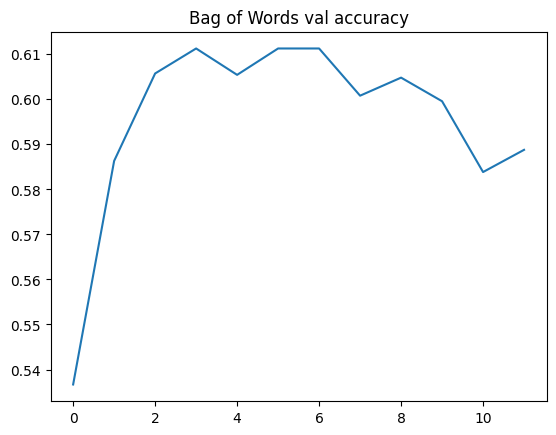

In [6]:
import tensorflow as tf
data = []
for event in tf.compat.v1.train.summary_iterator('/home/NLP-reviews/logs/lightning_logs/version_3/events.out.tfevents.1718567456.b2d40c3ca9f2.387.0'):
    for value in event.summary.value:
            if value.tag == 'val_acc':
                data.append(value.simple_value)
plt.plot(data)
plt.title("Bag of Words val accuracy")
plt.show()